In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import os
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        self.res_block = nn.Sequential(
            nn.Conv2d(in_c, in_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_c),
            nn.PReLU(num_parameters=in_c),
            nn.Conv2d(in_c, in_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_c)
        )

    def forward(self, x):
        return x + self.res_block(x)


class UpsampleBlock(nn.Module):
    def __init__(self, in_c, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_c, in_c * scale_factor ** 2, 3, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)
        self.act = nn.PReLU(num_parameters=in_c)

    def forward(self, x):
        return self.act(self.ps(self.conv(x)))


class Generator(nn.Module):
    def __init__(self, in_c=3, num_c=64, num_res_blocks=16):
        super().__init__()
        # Enter layer
        self.enter_layer = nn.Sequential(
            nn.Conv2d(in_c, num_c, kernel_size=9, stride=1, padding=4),
            nn.PReLU(num_parameters=num_c)
        )
        # Residual layers
        self.res_layers = nn.Sequential(*[ResidualBlock(num_c) for _ in range(num_res_blocks)])
        # Post residual layer
        self.postres_layer = nn.Sequential(
            nn.Conv2d(num_c, num_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_c)
        )
        # Upsampling layers
        self.upsample_layers = nn.Sequential(UpsampleBlock(num_c, 2), UpsampleBlock(num_c, 2))
        # Output layer
        self.output = nn.Conv2d(num_c, in_c, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        out1 = self.enter_layer(x)       # goes to skip connection
        x = self.res_layers(out1)
        x = self.postres_layer(x) + out1 # skip connection
        x = self.upsample_layers(x)
        return torch.tanh(self.output(x))

In [ ]:
def denormalize(tensor):
    return tensor * 0.5 + 0.5

def show_results(lr, result, hr):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 10))
    ax[0].imshow(lr)
    ax[0].set_title('LR Image')
    ax[1].imshow(result)
    ax[1].set_title('Superresolution')
    ax[2].imshow(hr)
    ax[2].set_title('Orig. HR image')

In [ ]:
model = Generator()
checkpoint = torch.load('gen.tar', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

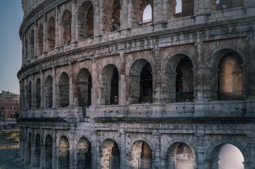

In [ ]:
lr = Image.open('/content/0864x8.png')
lr

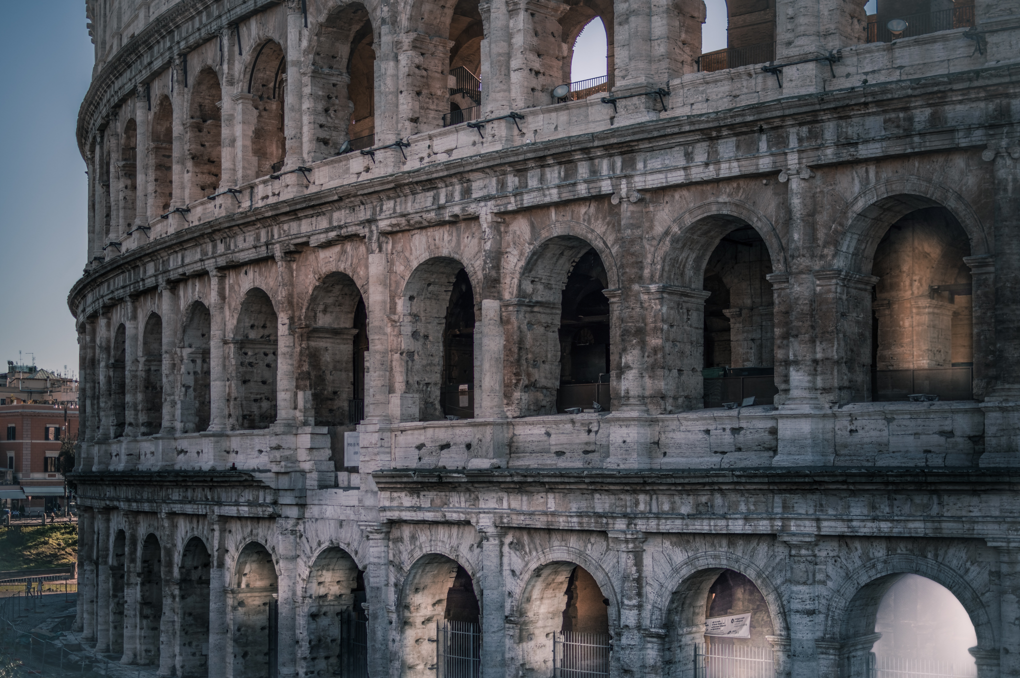

In [ ]:
hr = Image.open('/content/0864x2.png')
hr

In [ ]:
img_transforms = transforms.Compose([
    transforms.ToTensor()
])

tensor = img_transforms(lr).unsqueeze(0)
result = transforms.ToPILImage()(denormalize(model(tensor).squeeze()))

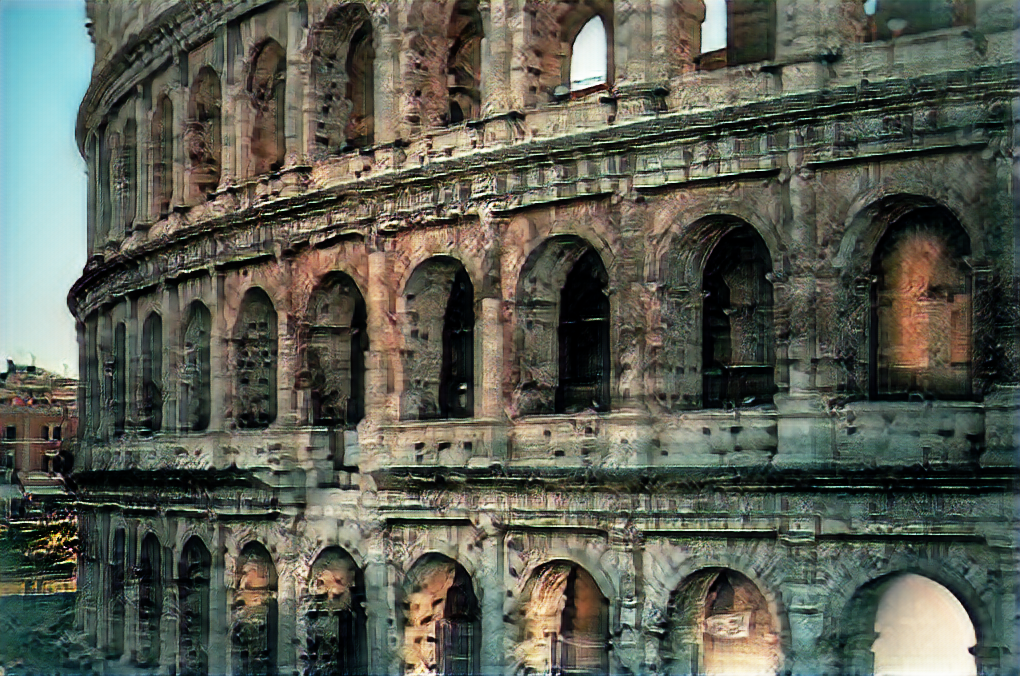

In [ ]:
result

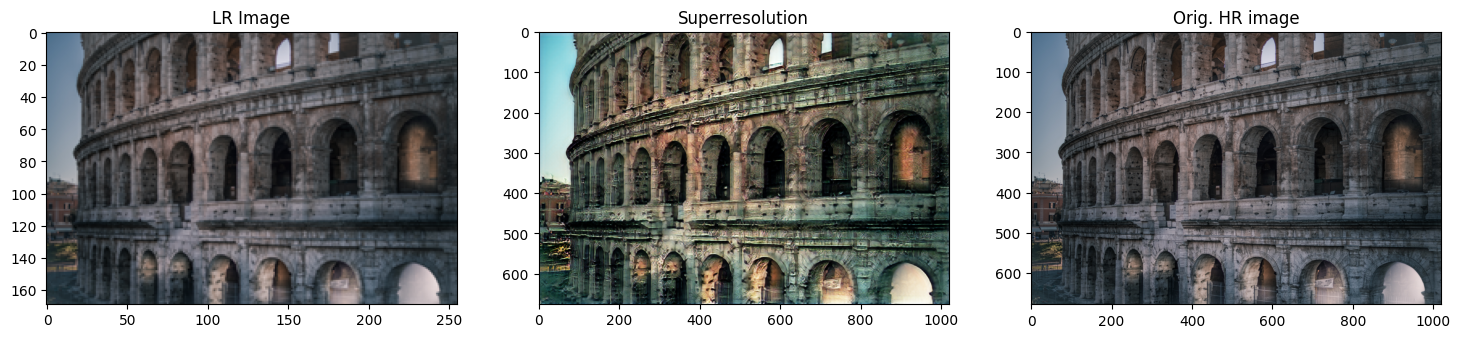

In [ ]:
show_results(lr, result, hr)